# Exploratory analysis of packing effective area: Random Forest Regression


# Data import and cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from scipy.stats import t
import itertools
!pip install shap
import shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 8.3 MB/s eta 0:00:00


In [2]:
#Import unscaled CSV data
url = 'https://raw.githubusercontent.com/bdrewr/FinalProjectSDS384/main/ExcelAreaFiles/AE_UTSRP_Filled_2.csv' #unscaled data new URL
data_unscaled = pd.read_csv(url)
data_unscaled = data_unscaled.drop(labels=['Unnamed: 0', 'void fraction', 'Glycerol', '[alk]'], axis='columns')
data_unscaled.info()
data_unscaled.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Packing Type            983 non-null    object 
 1   Height                  983 non-null    float64
 2   specific area           983 non-null    int64  
 3   Corrugation angle       902 non-null    float64
 4   S, Channel Side         902 non-null    float64
 5   B, Channel Base         902 non-null    float64
 6   h, Crimp height         902 non-null    float64
 7   packing element height  409 non-null    float64
 8   LP/A                    840 non-null    float64
 9   L                       983 non-null    float64
 10  uG                      983 non-null    float64
 11  T Corr                  983 non-null    float64
 12  DelP                    493 non-null    float64
 13  k OH E-3                830 non-null    float64
 14  DCO2 E9                 983 non-null    fl

,Packing Type,Height,specific area,Corrugation angle,"S, Channel Side","B, Channel Base","h, Crimp height",packing element height,LP/A,L,...,DCO2 E9,HCO2 E-5,[OH-],CO2 in,CO2 out,Fractional Area,ReL,WeL E4,FrL,Who?
0,M250Y,3.1,250,45.0,0.16,0.024,0.011,242.4242,242424.24,2.0,...,1.49,21.8,0.1055,411.0,302.0,0.67,2.70,10.0,0.64,Tsai
1,M250Y,3.1,250,45.0,0.16,0.024,0.011,242.4242,242424.24,6.0,...,1.47,21.6,0.1020,410.0,286.0,0.80,6.40,45.0,1.51,Tsai
2,M250Y,3.1,250,45.0,0.16,0.024,0.011,242.4242,242424.24,12.0,...,1.42,20.8,0.1009,410.0,282.0,0.84,12.54,146.0,2.96,Tsai
3,M250Y,3.1,250,45.0,0.16,0.024,0.011,242.4242,242424.24,18.0,...,1.40,20.6,0.1007,409.0,279.0,0.88,18.46,284.0,4.35,Tsai
4,M250Y,3.1,250,45.0,0.16,0.024,0.011,242.4242,242424.24,24.0,...,1.39,20.3,0.0997,409.0,276.0,0.91,24.34,457.0,5.74,Tsai


In [3]:
#MinMax scaling (no scaling of fractional area)
scaler = MinMaxScaler()
unscaled_columns = ['Packing Type', 'Who?', 'Fractional Area']
columns_to_scale = [i for i in data_unscaled.columns if i not in unscaled_columns]
data = pd.DataFrame(data=scaler.fit_transform(data_unscaled[columns_to_scale]), columns = columns_to_scale)
data[unscaled_columns] = data_unscaled[unscaled_columns]
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Height                  983 non-null    float64
 1   specific area           983 non-null    float64
 2   Corrugation angle       902 non-null    float64
 3   S, Channel Side         902 non-null    float64
 4   B, Channel Base         902 non-null    float64
 5   h, Crimp height         902 non-null    float64
 6   packing element height  409 non-null    float64
 7   LP/A                    840 non-null    float64
 8   L                       983 non-null    float64
 9   uG                      983 non-null    float64
 10  T Corr                  983 non-null    float64
 11  DelP                    493 non-null    float64
 12  k OH E-3                830 non-null    float64
 13  DCO2 E9                 983 non-null    float64
 14  HCO2 E-5                983 non-null    fl

,Height,specific area,Corrugation angle,"S, Channel Side","B, Channel Base","h, Crimp height",packing element height,LP/A,L,uG,...,HCO2 E-5,[OH-],CO2 in,CO2 out,ReL,WeL E4,FrL,Packing Type,Who?,Fractional Area
0,0.756098,0.426606,0.0,0.018784,0.001502,0.00147,0.019007,1.0,0.011080,0.489474,...,0.006397,0.782934,0.454049,0.839744,0.012465,0.000378,0.012551,M250Y,Tsai,0.67
1,0.756098,0.426606,0.0,0.018784,0.001502,0.00147,0.019007,1.0,0.066482,0.489474,...,0.006061,0.730539,0.444950,0.788462,0.030410,0.002033,0.030453,M250Y,Tsai,0.80
2,0.756098,0.426606,0.0,0.018784,0.001502,0.00147,0.019007,1.0,0.149584,0.489474,...,0.004714,0.714072,0.444950,0.775641,0.060190,0.006808,0.060288,M250Y,Tsai,0.84
3,0.756098,0.426606,0.0,0.018784,0.001502,0.00147,0.019007,1.0,0.232687,0.489474,...,0.004377,0.711078,0.435851,0.766026,0.088903,0.013333,0.088889,M250Y,Tsai,0.88
4,0.756098,0.426606,0.0,0.018784,0.001502,0.00147,0.019007,1.0,0.315789,0.489474,...,0.003872,0.696108,0.435851,0.756410,0.117422,0.021512,0.117490,M250Y,Tsai,0.91


In [4]:
#data.describe()
data_unscaled.describe()

,Height,specific area,Corrugation angle,"S, Channel Side","B, Channel Base","h, Crimp height",packing element height,LP/A,L,uG,...,k OH E-3,DCO2 E9,HCO2 E-5,[OH-],CO2 in,CO2 out,Fractional Area,ReL,WeL E4,FrL
count,983.000000,983.000000,902.000000,902.000000,902.000000,902.000000,409.000000,840.000000,983.000000,983.000000,...,830.000000,983.000000,983.000000,830.000000,983.000000,983.000000,983.000000,493.000000,493.000000,493.000000
mean,2.994629,277.942014,48.952328,0.862130,1.003318,0.678814,301.604222,35181.541357,26.649237,1.074181,...,8.447928,1.927121,82.566531,0.091161,394.933978,201.243337,0.889379,21.660325,854.789047,5.226349
std,0.113509,114.566213,7.116827,2.441124,2.898869,1.973076,116.119327,85068.078036,20.909195,0.416657,...,3.050439,0.441880,128.120549,0.014506,13.231757,63.729181,0.207209,31.744756,2111.339513,7.566853
min,2.790000,64.000000,45.000000,0.008000,0.009600,0.001400,237.107300,57.861640,1.200000,0.570000,...,2.750000,0.090000,18.000000,0.053200,361.100000,40.000000,0.400000,0.130000,2.000000,0.030000
25%,2.910000,250.000000,45.000000,0.013500,0.019750,0.010000,237.107300,237.110000,9.000000,0.600000,...,5.800000,1.695000,27.100000,0.079900,387.000000,151.000000,0.730000,3.180000,41.000000,0.770000
50%,3.000000,250.000000,45.000000,0.017000,0.024100,0.011000,242.424200,325.000000,24.000000,1.000000,...,8.600000,2.020000,32.200000,0.092150,392.000000,203.000000,0.870000,9.210000,163.000000,2.170000
75%,3.100000,350.000000,45.000000,0.069000,0.027000,0.015000,242.424200,516.850000,37.000000,1.490000,...,10.810000,2.220000,35.900000,0.100000,402.000000,250.500000,1.020000,26.490000,776.000000,6.250000
max,3.200000,500.000000,70.000000,8.100000,9.600000,6.530000,516.845300,242424.240000,73.400000,2.470000,...,15.390000,2.730000,612.000000,0.120000,471.000000,352.000000,1.590000,206.310000,21153.000000,48.630000


In [5]:
#test un-scaling
data_inverted = pd.DataFrame(data=scaler.inverse_transform(data[columns_to_scale]), columns=columns_to_scale)
data_inverted[unscaled_columns] = data[unscaled_columns]
data_inverted.head(5)

,Height,specific area,Corrugation angle,"S, Channel Side","B, Channel Base","h, Crimp height",packing element height,LP/A,L,uG,...,HCO2 E-5,[OH-],CO2 in,CO2 out,ReL,WeL E4,FrL,Packing Type,Who?,Fractional Area
0,3.1,250.0,45.0,0.16,0.024,0.011,242.4242,242424.24,2.0,1.5,...,21.8,0.1055,411.0,302.0,2.70,10.0,0.64,M250Y,Tsai,0.67
1,3.1,250.0,45.0,0.16,0.024,0.011,242.4242,242424.24,6.0,1.5,...,21.6,0.1020,410.0,286.0,6.40,45.0,1.51,M250Y,Tsai,0.80
2,3.1,250.0,45.0,0.16,0.024,0.011,242.4242,242424.24,12.0,1.5,...,20.8,0.1009,410.0,282.0,12.54,146.0,2.96,M250Y,Tsai,0.84
3,3.1,250.0,45.0,0.16,0.024,0.011,242.4242,242424.24,18.0,1.5,...,20.6,0.1007,409.0,279.0,18.46,284.0,4.35,M250Y,Tsai,0.88
4,3.1,250.0,45.0,0.16,0.024,0.011,242.4242,242424.24,24.0,1.5,...,20.3,0.0997,409.0,276.0,24.34,457.0,5.74,M250Y,Tsai,0.91


In [6]:
#Cleanup and imputing missing data
drop_labels = [
    "CO2 in",
    "CO2 out",
    "k OH E-3",
    "[OH-]",
    "HCO2 E-5",
    'packing element height',
    'DelP',
    'ReL',
    #'WeL E4',
    #'FrL',
]
data_clean = data.drop(labels=drop_labels, axis='columns')

def impute_mean(df, fill_list):
  '''impute empty cells in dataframe 'df' w/ mean value'''
  for label in fill_list:
    if df[label].dtype == float:
      print(f"Filling {df[label].isna().sum()} ({df[label].isna().sum()/(df[label].isna().sum()+df[label].count().sum())*100:.1f}%) NaN values in column \'{label}\' with mean value ({df[label].mean():.3f})")
      df[label].fillna(df[label].mean(), inplace=True)
    else:
      print(f"Skipping column '{label}'")
  return df

impute_mean(data_clean, list(data_clean.columns))
data_clean.info()

Filling 0 (0.0%) NaN values in column 'Height' with mean value (0.499)
Filling 0 (0.0%) NaN values in column 'specific area' with mean value (0.491)
Filling 81 (8.2%) NaN values in column 'Corrugation angle' with mean value (0.158)
Filling 81 (8.2%) NaN values in column 'S, Channel Side' with mean value (0.106)
Filling 81 (8.2%) NaN values in column 'B, Channel Base' with mean value (0.104)
Filling 81 (8.2%) NaN values in column 'h, Crimp height' with mean value (0.104)
Filling 143 (14.5%) NaN values in column 'LP/A' with mean value (0.145)
Filling 0 (0.0%) NaN values in column 'L' with mean value (0.352)
Filling 0 (0.0%) NaN values in column 'uG' with mean value (0.265)
Filling 0 (0.0%) NaN values in column 'T Corr' with mean value (0.595)
Filling 0 (0.0%) NaN values in column 'DCO2 E9' with mean value (0.696)
Filling 490 (49.8%) NaN values in column 'WeL E4' with mean value (0.040)
Filling 490 (49.8%) NaN values in column 'FrL' with mean value (0.107)
Skipping column 'Packing Type'
S

# Structured Packing Random Forest Regression

In [7]:
#mask out random packings (Raschig RSR types)
randoms = data_clean["Packing Type"].str.startswith("RSR")
data_struct = data_clean.loc[~randoms]
print("STRUCTURED PACKING DATA:")
data_struct.info()
data_struct.describe()

STRUCTURED PACKING DATA:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 902 entries, 0 to 959
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Height             902 non-null    float64
 1   specific area      902 non-null    float64
 2   Corrugation angle  902 non-null    float64
 3   S, Channel Side    902 non-null    float64
 4   B, Channel Base    902 non-null    float64
 5   h, Crimp height    902 non-null    float64
 6   LP/A               902 non-null    float64
 7   L                  902 non-null    float64
 8   uG                 902 non-null    float64
 9   T Corr             902 non-null    float64
 10  DCO2 E9            902 non-null    float64
 11  WeL E4             902 non-null    float64
 12  FrL                902 non-null    float64
 13  Packing Type       902 non-null    object 
 14  Who?               902 non-null    object 
 15  Fractional Area    902 non-null    float64
dtypes

,Height,specific area,Corrugation angle,"S, Channel Side","B, Channel Base","h, Crimp height",LP/A,L,uG,T Corr,DCO2 E9,WeL E4,FrL,Fractional Area
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000
mean,0.516495,0.505681,0.158093,0.105552,0.103616,0.103761,0.144920,0.342833,0.266233,0.583490,0.685228,0.040319,0.106921,0.874823
std,0.277184,0.265000,0.284673,0.301671,0.302268,0.302220,0.338698,0.286412,0.217951,0.220872,0.167444,0.073764,0.115053,0.195393
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000
25%,0.317073,0.426606,0.000000,0.000680,0.001058,0.001317,0.000740,0.069252,0.015789,0.442935,0.602273,0.006146,0.039609,0.730000
50%,0.536585,0.426606,0.000000,0.001112,0.001512,0.001470,0.001102,0.315789,0.226316,0.619565,0.719697,0.040319,0.106921,0.860000
75%,0.756098,0.655963,0.000000,0.007538,0.001814,0.002083,0.001894,0.495845,0.484211,0.759964,0.795455,0.040319,0.106921,1.010000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985507,0.954545,1.000000,1.000000,1.550000


In [31]:
#Set up X and Y and define function to fit multiple iterations of Random Forest
X_base = data_struct.drop(labels='Fractional Area', axis='columns')
#drop columns that are not floats
for column in list(data_clean.columns):
  if data_clean[column].dtype != float:
    X_base = X_base.drop(labels=column, axis='columns')
Y = data_struct['Fractional Area'].values

rf = RandomForestRegressor()
def fit_RF(rf, X, Y, iterations=50, test_size=0.2, print_stats=True):
  """Fit multiple iterations of Random Forest and report statistics.
  Returns numpy arrays of train stats and test stats of shape [4,iterations]
  where column [0] is MSE, [1] is R2, [2] is MAPE, [3] is MAE"""
  train_stats = np.zeros((4,iterations))
  test_stats = np.zeros((4,iterations))
  for i in range(iterations):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=i)
    rf.fit(X_train, Y_train)
    Y_pred_train = rf.predict(X_train)
    Y_pred_test = rf.predict(X_test)
    train_stats[0,i] = mean_squared_error(Y_train, Y_pred_train)
    train_stats[1,i] = r2_score(Y_train, Y_pred_train)
    train_stats[2,i] = mean_absolute_percentage_error(Y_train, Y_pred_train)
    train_stats[3,i] = mean_absolute_error(Y_train, Y_pred_train)
    test_stats[0,i] = mean_squared_error(Y_test, Y_pred_test)
    test_stats[1,i] = r2_score(Y_test, Y_pred_test)
    test_stats[2,i] = mean_absolute_percentage_error(Y_test, Y_pred_test)
    test_stats[3,i] = mean_absolute_error(Y_test, Y_pred_test)
  if print_stats: 
    # Calculate the mean and standard deviation of the performance metrics
    mse_train_mean = np.mean(train_stats[0,:])
    mse_train_std = np.std(train_stats[0,:])
    r2_train_mean = np.mean(train_stats[1,:])
    r2_train_std = np.std(train_stats[1,:])
    mape_train_mean = np.mean(train_stats[2,:])
    mape_train_std = np.std(train_stats[2,:])
    mae_train_mean = np.mean(train_stats[3,:])
    mae_train_std = np.std(train_stats[3,:])

    mse_test_mean = np.mean(test_stats[0,:])
    mse_test_std = np.std(test_stats[0,:])
    r2_test_mean = np.mean(test_stats[1,:])
    r2_test_std = np.std(test_stats[1,:])
    mape_test_mean = np.mean(test_stats[2,:])
    mape_test_std = np.std(test_stats[2,:])
    mae_test_mean = np.mean(test_stats[3,:])
    mae_test_std = np.std(test_stats[3,:])

    # Calculate the t-score for a 95% confidence interval with (iterations - 1) degrees of freedom
    t_score = t.ppf(0.975, iterations - 1)
    
    # Calculate the confidence intervals for the performance metrics
    mse_train_ci = t_score * mse_train_std / np.sqrt(iterations)
    r2_train_ci = t_score * r2_train_std / np.sqrt(iterations)
    mape_train_ci = t_score * mape_train_std / np.sqrt(iterations)
    mae_train_ci = t_score * mae_train_std / np.sqrt(iterations)

    mse_test_ci = t_score * mse_test_std / np.sqrt(iterations)
    r2_test_ci = t_score * r2_test_std / np.sqrt(iterations)
    mape_test_ci = t_score * mape_test_std / np.sqrt(iterations)
    mae_test_ci = t_score * mae_test_std / np.sqrt(iterations)
    #Print scores w/ confidence intervals
    print(f"Training MSE: {mse_train_mean*100:.1f}% ± {mse_train_ci*100:.1f}%")
    print(f"Training R^2: {r2_train_mean*100:.1f}% ± {r2_train_ci*100:.1f}%")
    #print(f"Training MAPE: {mape_train_mean*100:.1f}% ± {mape_train_ci*100:.1f}%")
    print(f"Training MAE: {mae_train_mean*100:.1f}% ± {mae_train_ci*100:.1f}%")
    print(f"Testing MSE: {mse_test_mean*100:.1f}% ± {mse_test_ci*100:.1f}%")
    print(f"Testing R^2: {r2_test_mean*100:.1f}% ± {r2_test_ci*100:.1f}%")
    #print(f"Testing MAPE: {mape_test_mean*100:.1f}% ± {mape_test_ci*100:.1f}%")
    print(f"Testing MAE: {mae_test_mean*100:.1f}% ± {mae_test_ci*100:.1f}%")

  return [train_stats, test_stats]

In [32]:
#Fit using all features
train_stats_base, test_stats_base = fit_RF(rf, X_base, Y, iterations=100, test_size=0.2)

Training MSE: 0.0% ± 0.0%
Training R^2: 99.3% ± 0.0%
Training MAE: 1.2% ± 0.0%
Testing MSE: 0.2% ± 0.0%
Testing R^2: 95.1% ± 0.2%
Testing MAE: 3.2% ± 0.0%


**Best feature selection**

In [20]:
#Generate feature combinations
z=0
feature_combinations = []
#Every combination includes specific area, L, uG
fixed_features = ['specific area', 'L', 'uG']
test_features = [x for x in list(X_base.columns) if x not in fixed_features]
#for n in range(3,len(list(X_base.columns))):
for n in range(0,4):
  for combination in itertools.combinations(test_features, n):
    #print(combination)
    #train_stats, test_stats = fit_SVM(svm, X_base[list(combination)], Y, iterations=5, test_size=0.2, print_stats=True)
    z+=1
    feature_combinations.append(fixed_features + list(combination))

print(f"Feature combinations to be tested: {z}") 

#Calculate test set MSE for each feature combination
combination_scores = np.ones((3,z))
for i, combination in enumerate(feature_combinations):
  train_stats, test_stats = fit_RF(rf, X_base[list(combination)], Y, iterations=5, test_size=0.2, print_stats=False)
  combination_scores[0,i] = test_stats[0,:].mean()
  combination_scores[1,i] = test_stats[1,:].mean()
  combination_scores[2,i] = test_stats[2,:].mean()

#Pick best MSE
best_index = combination_scores[0,:].argmin()
best_R2 = combination_scores[1,:].argmax()
best_combo = feature_combinations[best_index]
print(f"Best test MSE is {combination_scores[0,best_index]*100:.1f}% at index {best_index}")
print(f"Best test R2 is {combination_scores[1,best_R2]*100:.1f}% at index {best_R2}")
print(f"Best combination (minimum MSE) is {best_combo}")

Feature combinations to be tested: 176
Best test MSE is 0.2% at index 158
Best test R2 is 94.7% at index 158
Best combination (minimum MSE) is ['specific area', 'L', 'uG', 'h, Crimp height', 'LP/A', 'WeL E4']


In [23]:
#Fit using best feature combination
#Redo scaling so it can be undone later
X_best = data_unscaled.loc[~randoms]
X_best = X_best[best_combo]
impute_mean(X_best, best_combo)
best_scaler = MinMaxScaler()
X_best = pd.DataFrame(data=best_scaler.fit_transform(X_best), columns=best_combo)

#Grid search w/ 5-fold CV to pick best hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
}
rf_best = RandomForestRegressor()
grid_search = GridSearchCV(rf_best, param_grid, cv=5, scoring='neg_mean_squared_error')
X_train, X_test, Y_train, Y_test = train_test_split(X_best, Y, test_size=0.2, random_state=17)
grid_search.fit(X_train, Y_train)
print("Best Hyperparameters:", grid_search.best_params_)
rf_best.set_params(**grid_search.best_params_)
train_stats_best, test_stats_best = fit_RF(rf_best, X_best, Y, iterations=100, test_size=0.2, print_stats=True)

Skipping column 'specific area'
Filling 0 (0.0%) NaN values in column 'L' with mean value (25.953)
Filling 0 (0.0%) NaN values in column 'uG' with mean value (1.076)
Filling 0 (0.0%) NaN values in column 'h, Crimp height' with mean value (0.679)
Filling 62 (6.9%) NaN values in column 'LP/A' with mean value (35181.541)
Filling 409 (45.3%) NaN values in column 'WeL E4' with mean value (854.789)


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Best Hyperparameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 150}
Training MSE: 0.0% ± 0.0%
Training R^2: 99.0% ± 0.0%
Training MAE: 1.4% ± 0.0%
Testing MSE: 0.2% ± 0.0%
Testing R^2: 94.5% ± 0.2%
Testing MAE: 3.4% ± 0.0%


**Reduced feature set**

In [24]:
#Fit using reduced feature combination
#Redo scaling so it can be undone later
reduced_list = [
    'specific area',
    'L',
    'uG',
    'T Corr',
]
X_reduced = data_unscaled.loc[~randoms]
X_reduced = X_reduced[reduced_list]
impute_mean(X_reduced, reduced_list)
reduced_scaler = MinMaxScaler()
X_reduced = pd.DataFrame(data=reduced_scaler.fit_transform(X_reduced), columns=reduced_list)

#Grid search w/ 5-fold CV to pick best hyperparameters
param_grid_reduced = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
}
rf_reduced = RandomForestRegressor()
grid_search_reduced = GridSearchCV(rf_reduced, param_grid_reduced, cv=5)
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=17)
grid_search_reduced.fit(X_train, Y_train)
print("Best Hyperparameters:", grid_search_reduced.best_params_)
rf_reduced.set_params(**grid_search_reduced.best_params_)
train_stats_reduced, test_stats_reduced = fit_RF(rf_reduced, X_reduced, Y, iterations=100, test_size=0.2, print_stats=True)

Skipping column 'specific area'
Filling 0 (0.0%) NaN values in column 'L' with mean value (25.953)
Filling 0 (0.0%) NaN values in column 'uG' with mean value (1.076)
Filling 0 (0.0%) NaN values in column 'T Corr' with mean value (23.804)


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
Training MSE: 0.1% ± 0.0%
Training R^2: 96.9% ± 0.0%
Training MAE: 2.7% ± 0.0%
Testing MSE: 0.5% ± 0.0%
Testing R^2: 87.6% ± 0.4%
Testing MAE: 5.2% ± 0.1%


# Parity Plots

In [33]:
#set DPI to be used for all plots
dpi=200
def predict_RF(rf, X, Y, test_size=0.2, random_state=17, print_stats=True):
  """Fit RF (one iteration) and return [Y_train, Y_test, Y_pred_train, Y_pred_test]"""
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
  rf.fit(X_train, Y_train)
  Y_pred_train = rf.predict(X_train)
  Y_pred_test = rf.predict(X_test)

  if print_stats: 
    # Calculate performance metrics
    mse_train = mean_squared_error(Y_train, Y_pred_train)
    r2_train = r2_score(Y_train, Y_pred_train)
    mape_train = mean_absolute_percentage_error(Y_train, Y_pred_train)

    mse_test = mean_squared_error(Y_test, Y_pred_test)
    r2_test = r2_score(Y_test, Y_pred_test)
    mape_test = mean_absolute_percentage_error(Y_test, Y_pred_test)

    mae_test = mean_absolute_error(Y_test, Y_pred_test)

    #Print scores
    print(f"Training MSE: {mse_train*100:.1f}%")
    print(f"Training R2: {r2_train*100:.1f}%")
    print(f"Training MAPE: {mape_train*100:.1f}%")
    print(f"Testing MSE: {mse_test*100:.1f}%")
    print(f"Testing R2: {r2_test*100:.1f}%")
    print(f"Testing MAPE: {mape_test*100:.1f}%")
    print(f"Testing MAE: {mae_test*100:.1f}%")

  return [Y_train, Y_test, Y_pred_train, Y_pred_test]

def parity_plot(Y_train, Y_test, Y_pred_train, Y_pred_test, name='X', dpi=200, size=2, error=0, titles=False, lim=2):
  """Make parity plots for training set and test set.
  NOTE these plots are actual values on X axis and predicted values on Y."""
  # create figure with two subplots
  #fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  #fig, axs = plt.subplots(2, 1, dpi=dpi, figsize=(5,10))
  fig, axs = plt.subplots(1, 2, dpi=dpi, figsize=(10,5))
  axs[0].set_box_aspect(1)
  axs[1].set_box_aspect(1)

  # plot parity plot with line of best fit for training data
  axs[0].scatter(Y_train, Y_pred_train, s=size)
  axs[0].plot(np.linspace(0, lim, 100), np.linspace(0, lim, 100), 'k--')
  axs[0].set_ylabel('Predicted values')
  axs[0].set_xlabel('Actual values')
  axs[0].set_xlim([0,lim])
  axs[0].set_ylim([0,lim])

  # plot parity plot with line of best fit for test data
  axs[1].scatter(Y_test, Y_pred_test, s=size)
  axs[1].plot(np.linspace(0, lim, 100), np.linspace(0, lim, 100), 'k--')
  axs[1].set_ylabel('Predicted values')
  axs[1].set_xlabel('Actual values')
  axs[1].set_xlim([0,lim])
  axs[1].set_ylim([0,lim])

  if titles:
    axs[0].set_title('Parity plot for training data '+name)
    axs[1].set_title('Parity plot for test data '+name)


  if error>0:
    high = lim+lim*error/100
    low = lim-lim*error/100
    axs[0].plot(np.linspace(0,lim,100), np.linspace(0,high,100), '--', color='red')
    axs[0].plot(np.linspace(0,lim,100), np.linspace(0,low,100), '--', color='red')
    axs[1].plot(np.linspace(0,lim,100), np.linspace(0,high,100), '--', color='red')
    axs[1].plot(np.linspace(0,lim,100), np.linspace(0,low,100), '--', color='red')
    axs[0].text(0.1, 0.35, f"+{error}%", color='red', fontsize=8, fontweight='bold')
    axs[0].text(0.3, 0.2, f"-{error}%", color='red', fontsize=8, fontweight='bold')
    axs[1].text(0.1, 0.35, f"+{error}%", color='red', fontsize=8, fontweight='bold')
    axs[1].text(0.3, 0.2, f"-{error}%", color='red', fontsize=8, fontweight='bold')


  # show the plots
  plt.tight_layout()
  plt.show()

  return

Training MSE: 0.0%
Training R2: 99.3%
Training MAPE: 1.4%
Testing MSE: 0.2%
Testing R2: 95.3%
Testing MAPE: 3.7%
Testing MAE: 3.1%


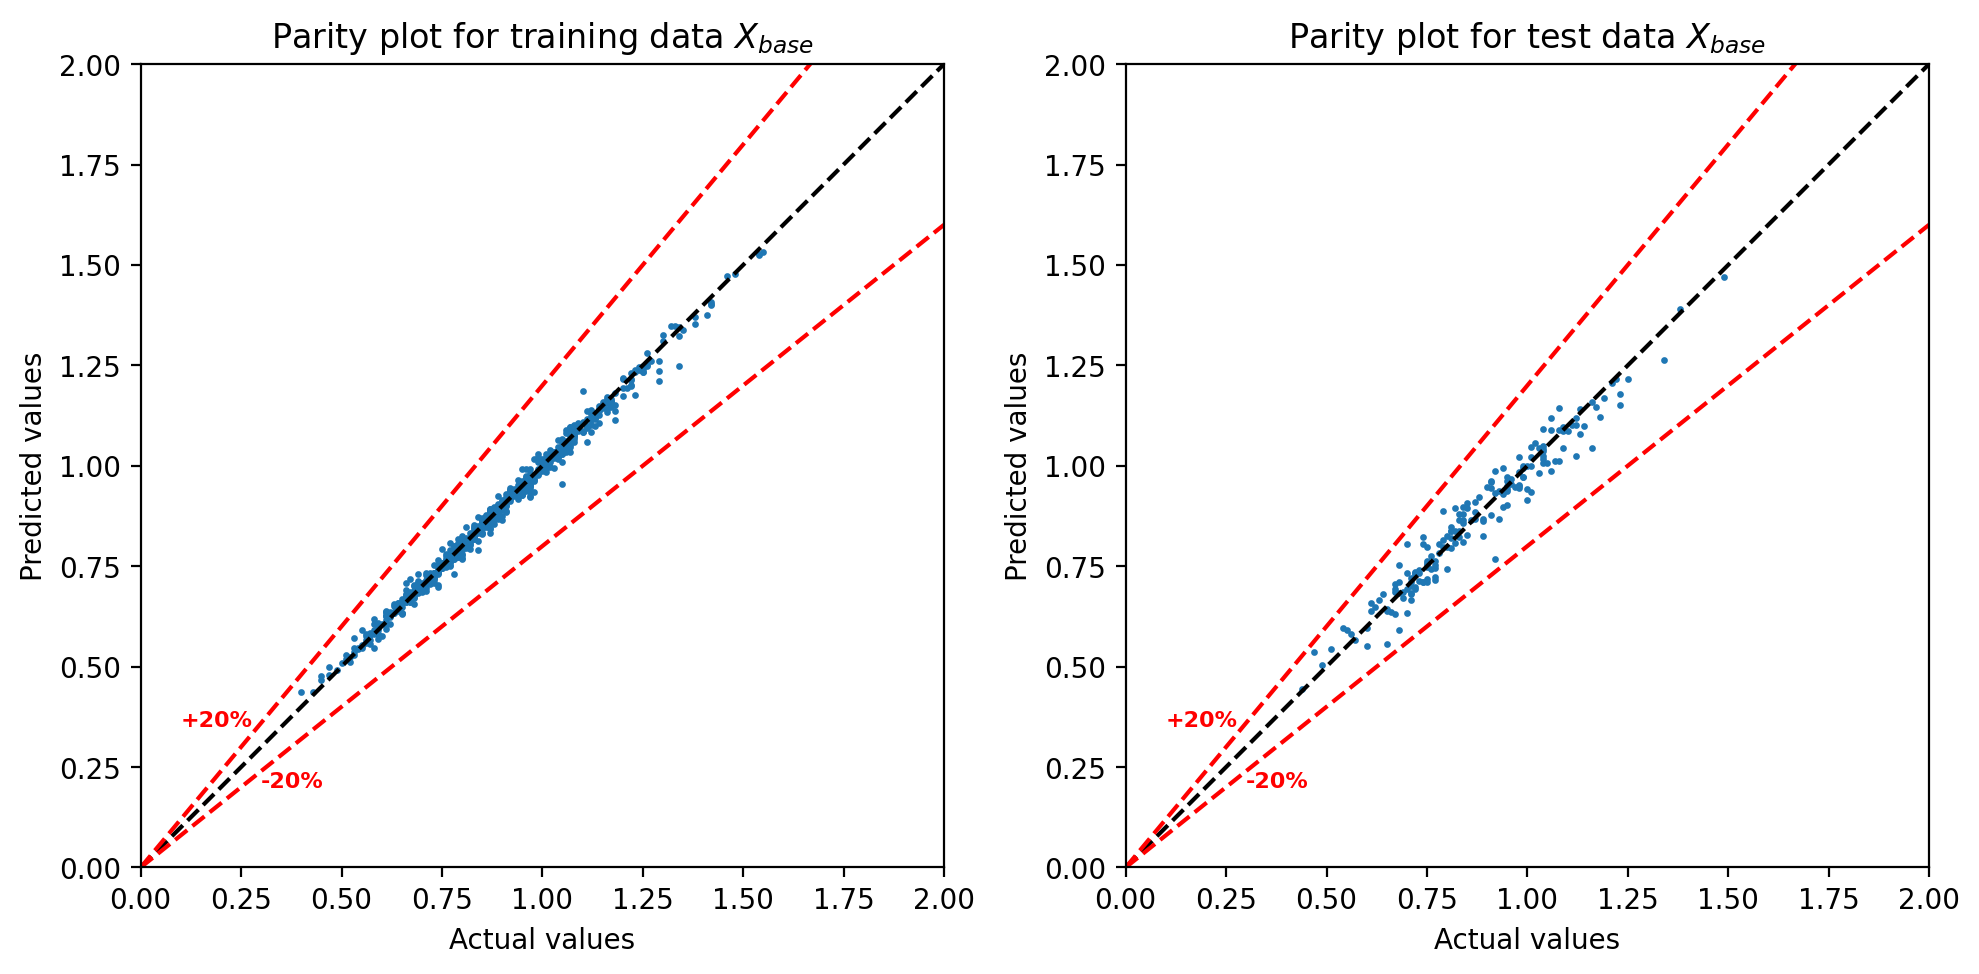

In [34]:
#fit and plot X_base (all features)
Y_train, Y_test, Y_pred_train, Y_pred_test = predict_RF(rf, X_base, Y)
parity_plot(Y_train, Y_test, Y_pred_train, Y_pred_test, name=r'$X_{base}$', error=20, dpi=dpi, titles=True)

Training MSE: 0.1%
Training R2: 96.6%
Training MAPE: 3.4%
Testing MSE: 0.4%
Testing R2: 88.2%
Testing MAPE: 6.1%
Testing MAE: 5.1%


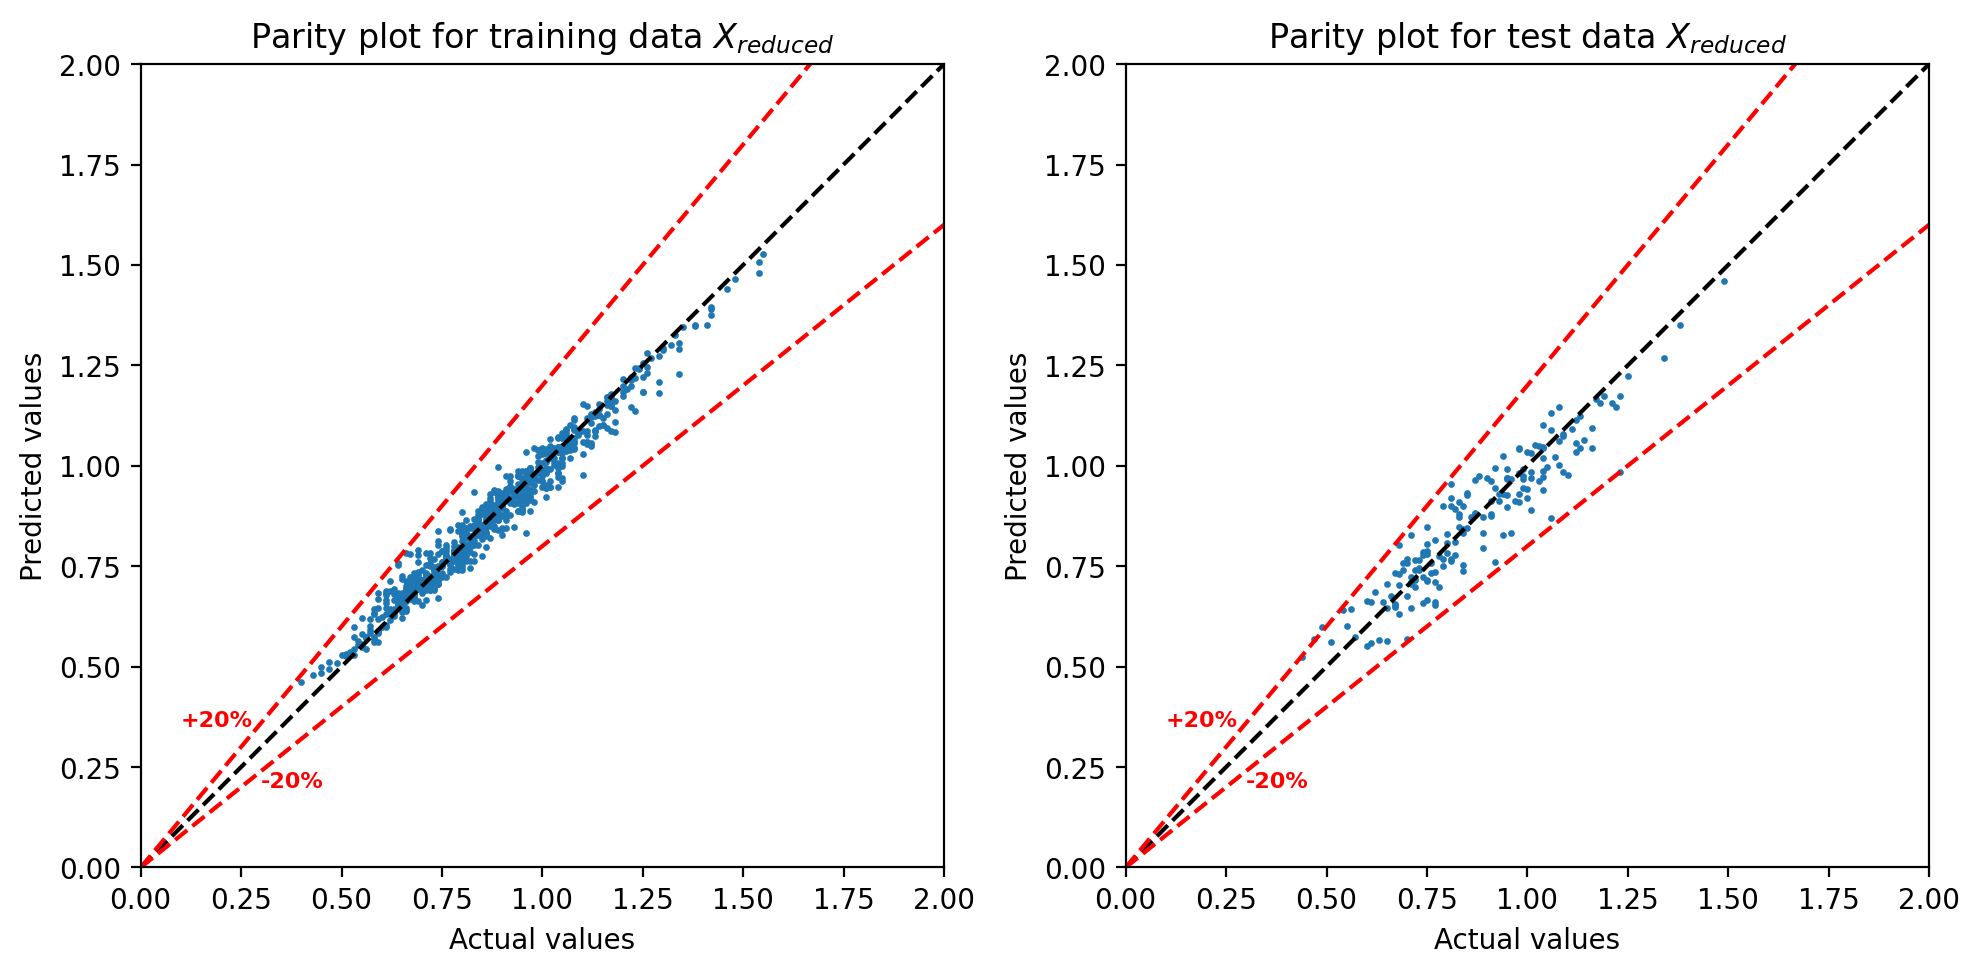

In [35]:
#fit and plot X_reduced
Y_train, Y_test, Y_pred_train, Y_pred_test = predict_RF(rf_reduced, X_reduced, Y)
parity_plot(Y_train, Y_test, Y_pred_train, Y_pred_test, name=r'$X_{reduced}$', error=20, dpi=dpi, titles=True)

Training MSE: 0.0%
Training R2: 99.1%
Training MAPE: 1.7%
Testing MSE: 0.2%
Testing R2: 94.8%
Testing MAPE: 4.2%
Testing MAE: 3.4%


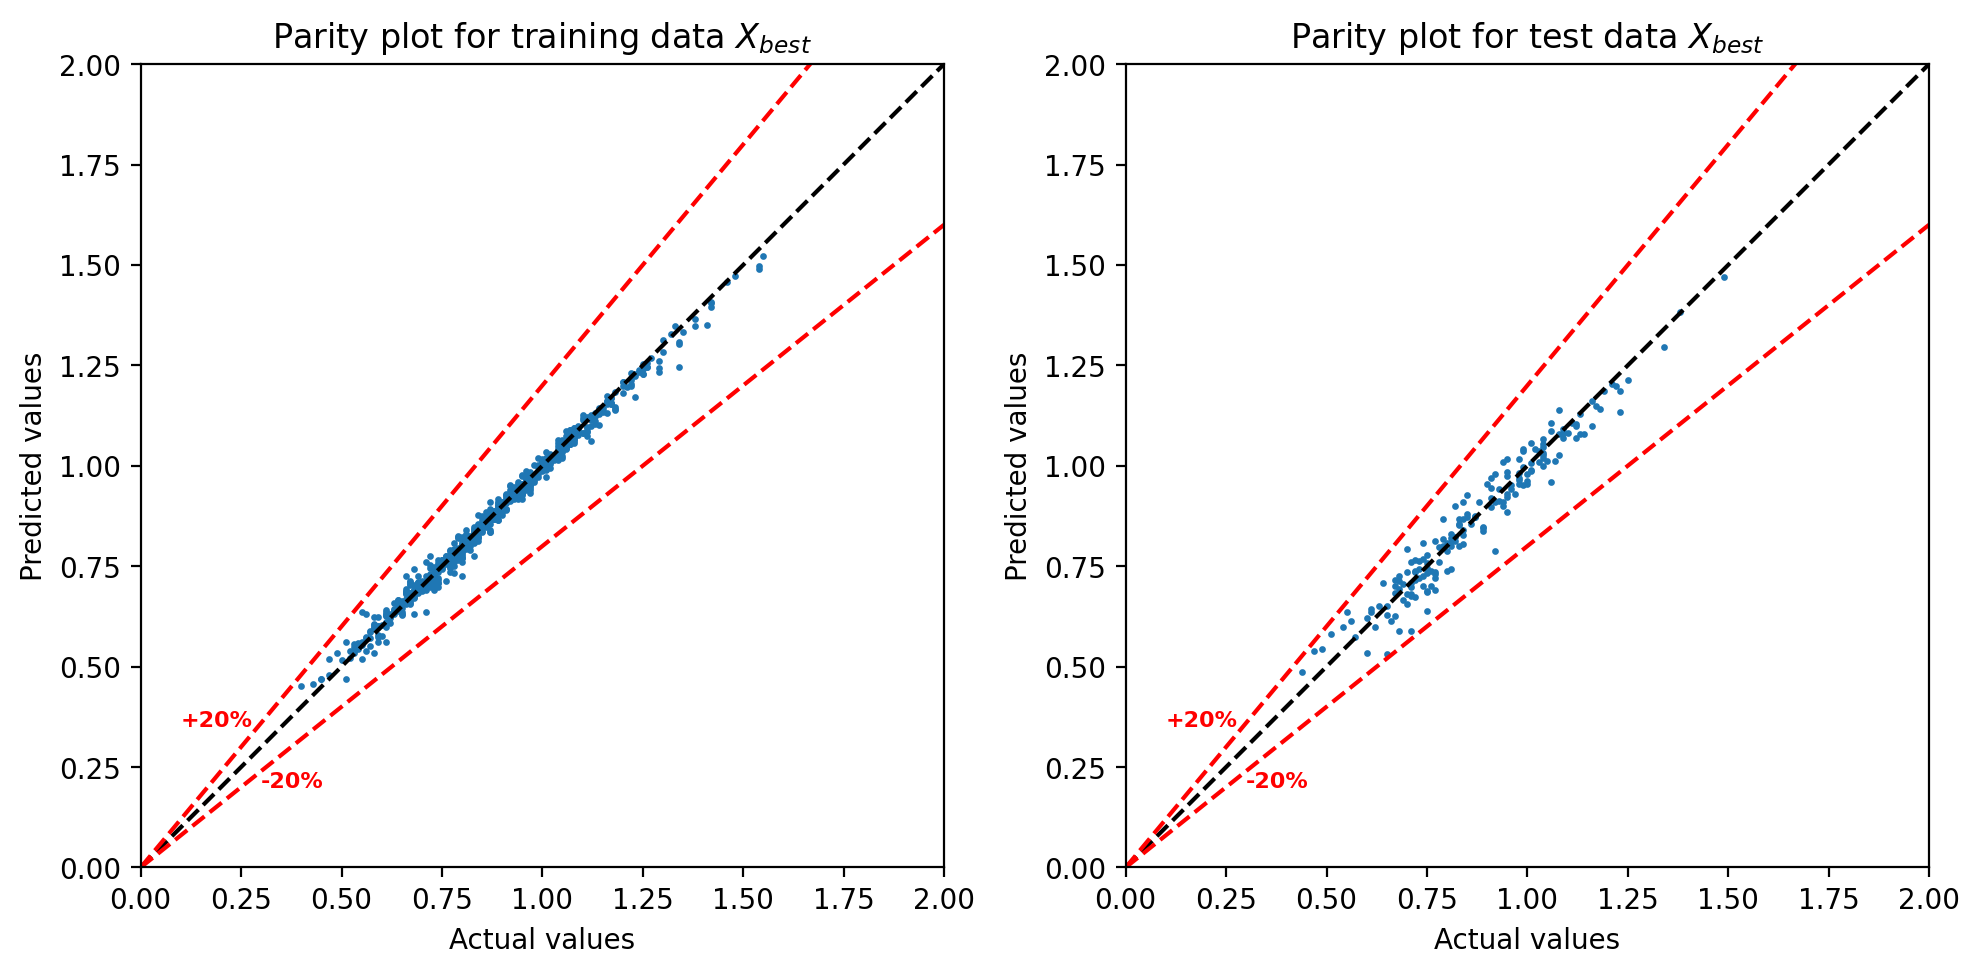

In [36]:
#fit and plot X_best
Y_train, Y_test, Y_pred_train, Y_pred_test = predict_RF(rf_best, X_best, Y)
parity_plot(Y_train, Y_test, Y_pred_train, Y_pred_test, name=r'$X_{best}$', error=20, dpi=dpi, titles=True)

In [37]:
def parity_plot_color(Y, Y_pred, colors, name='X', dpi=200, size=2, error=0, grouping='Packing Type', lim=2):
  """Make parity plot with color coding by packing type"""
  #fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  fig, axs = plt.subplots(1, 1, dpi=dpi, figsize=(8,8))
  axs.set_box_aspect(1)
  plt.tight_layout()

  # plot parity plot with line of best fit for training data
  #axs[0].scatter(Y_train, Y_pred_train, s=size)
  axs.plot(np.linspace(0, lim, 100), np.linspace(0, lim, 100), 'k--')
  axs.set_ylabel('Predicted values')
  axs.set_xlabel('Actual values')
  axs.set_xlim([0,lim])
  axs.set_ylim([0,lim])

  colors['Y'] = Y
  colors['Y_pred'] = Y_pred
  markers = itertools.cycle(['o','^','v','<','>','8','s','P','D'])


  for i, (category, group) in enumerate(colors.groupby(grouping)):
    axs.scatter(group['Y'], group['Y_pred'], label=category, s=size, marker=next(markers))

  axs.legend()

  axs.set_title('Parity plot of dataset '+name +' color-coded by '+grouping)


  if error>0:
    high = lim+lim*error/100
    low = lim-lim*error/100
    axs.plot(np.linspace(0,lim,100), np.linspace(0,high,100), '--', color='red')
    axs.plot(np.linspace(0,lim,100), np.linspace(0,low,100), '--', color='red')
    axs.text(0.5, 0.8, f"+{error}%", color='red', fontsize=12, fontweight='bold')
    axs.text(0.8, 0.6, f"-{error}%", color='red', fontsize=12, fontweight='bold')


  # show the plots
  plt.show()

  return

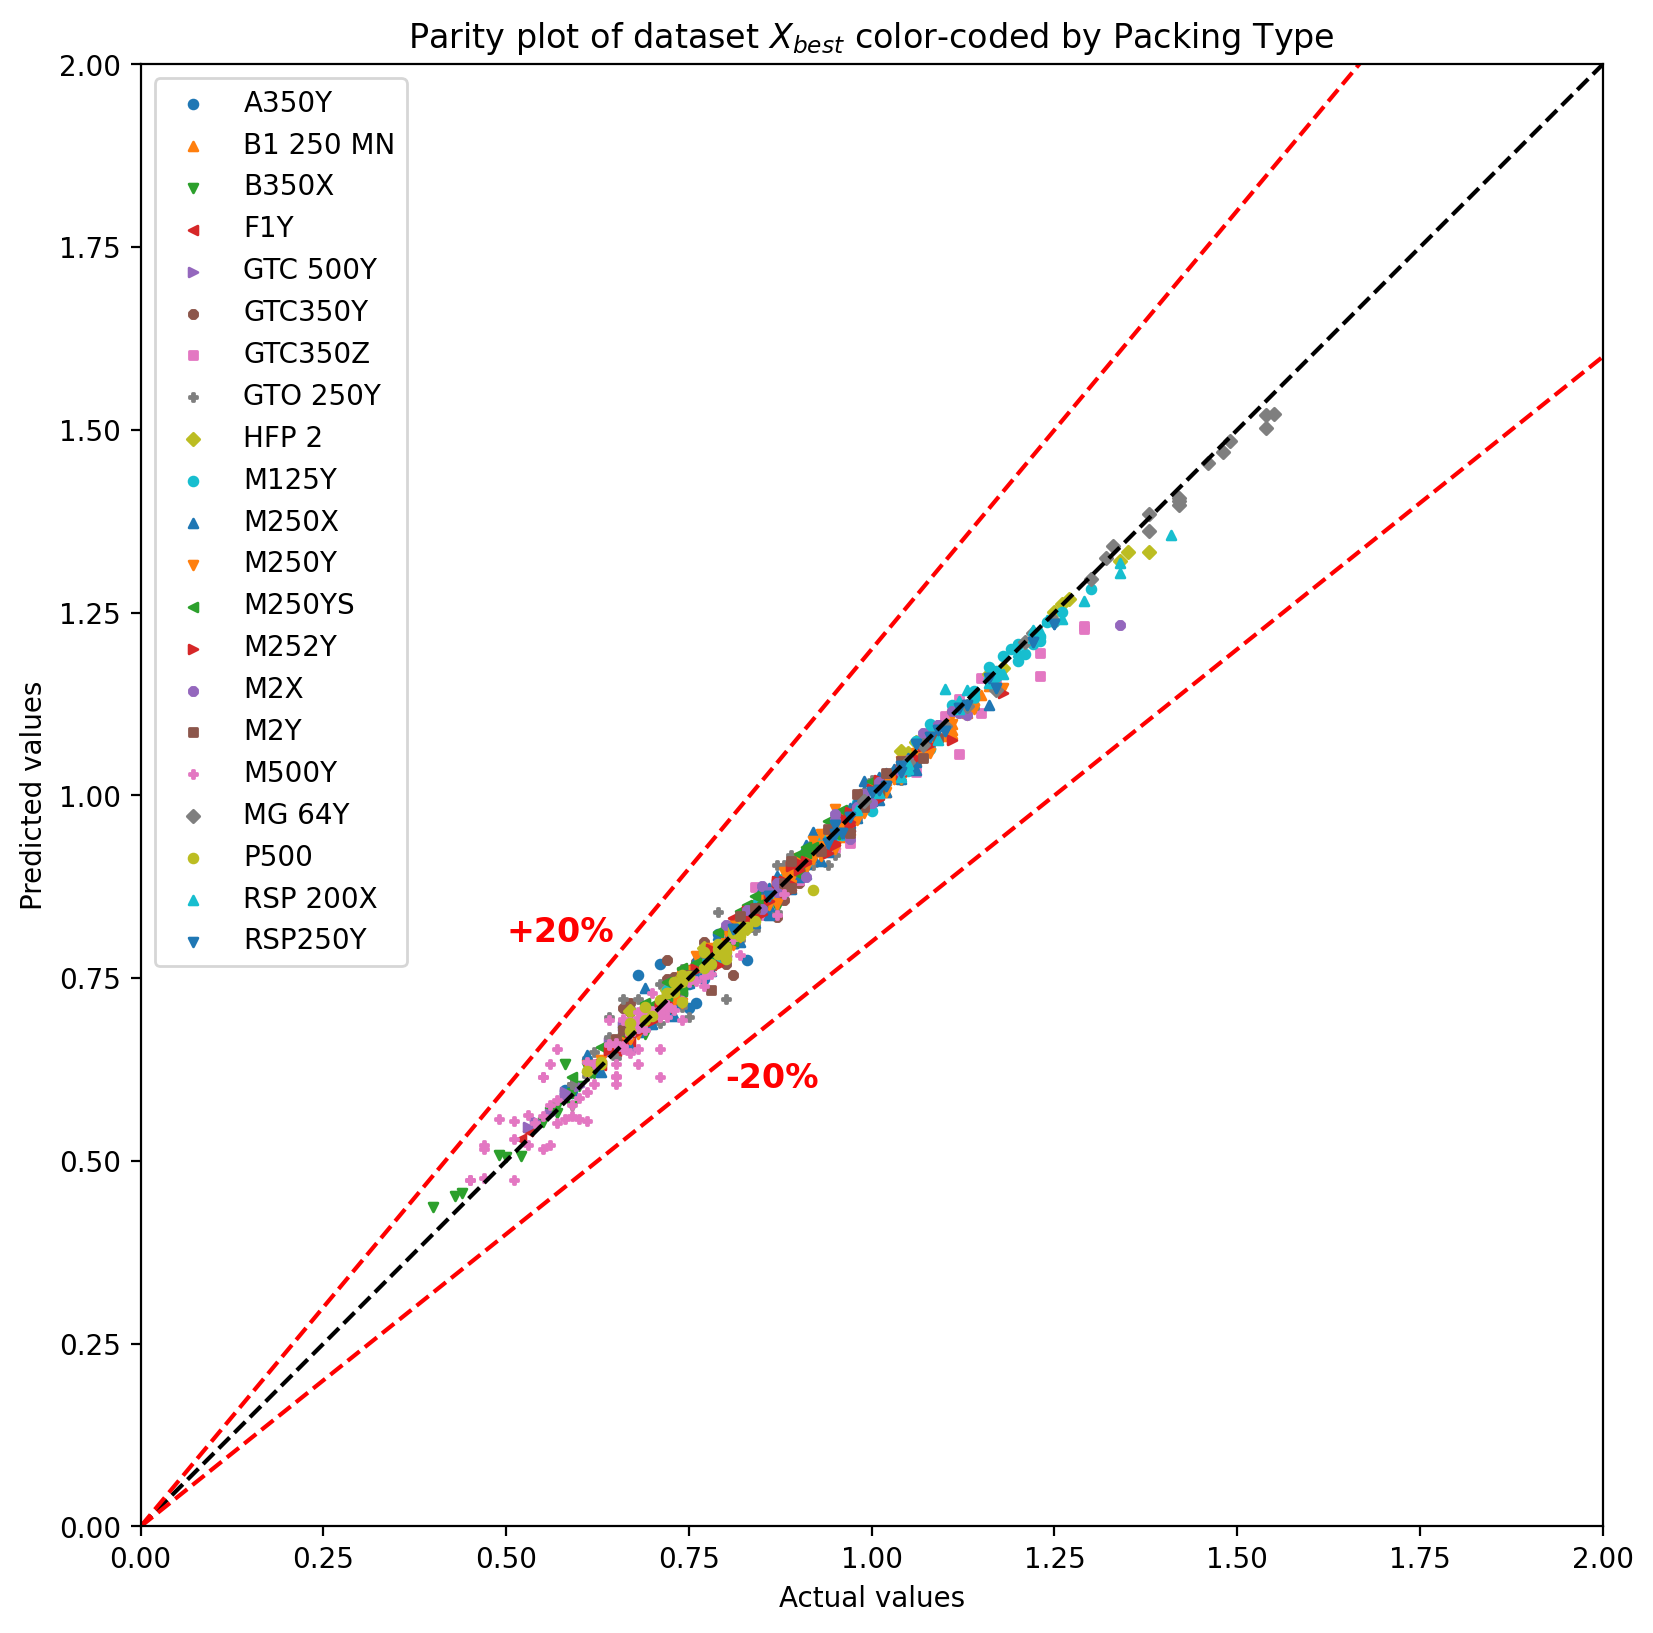

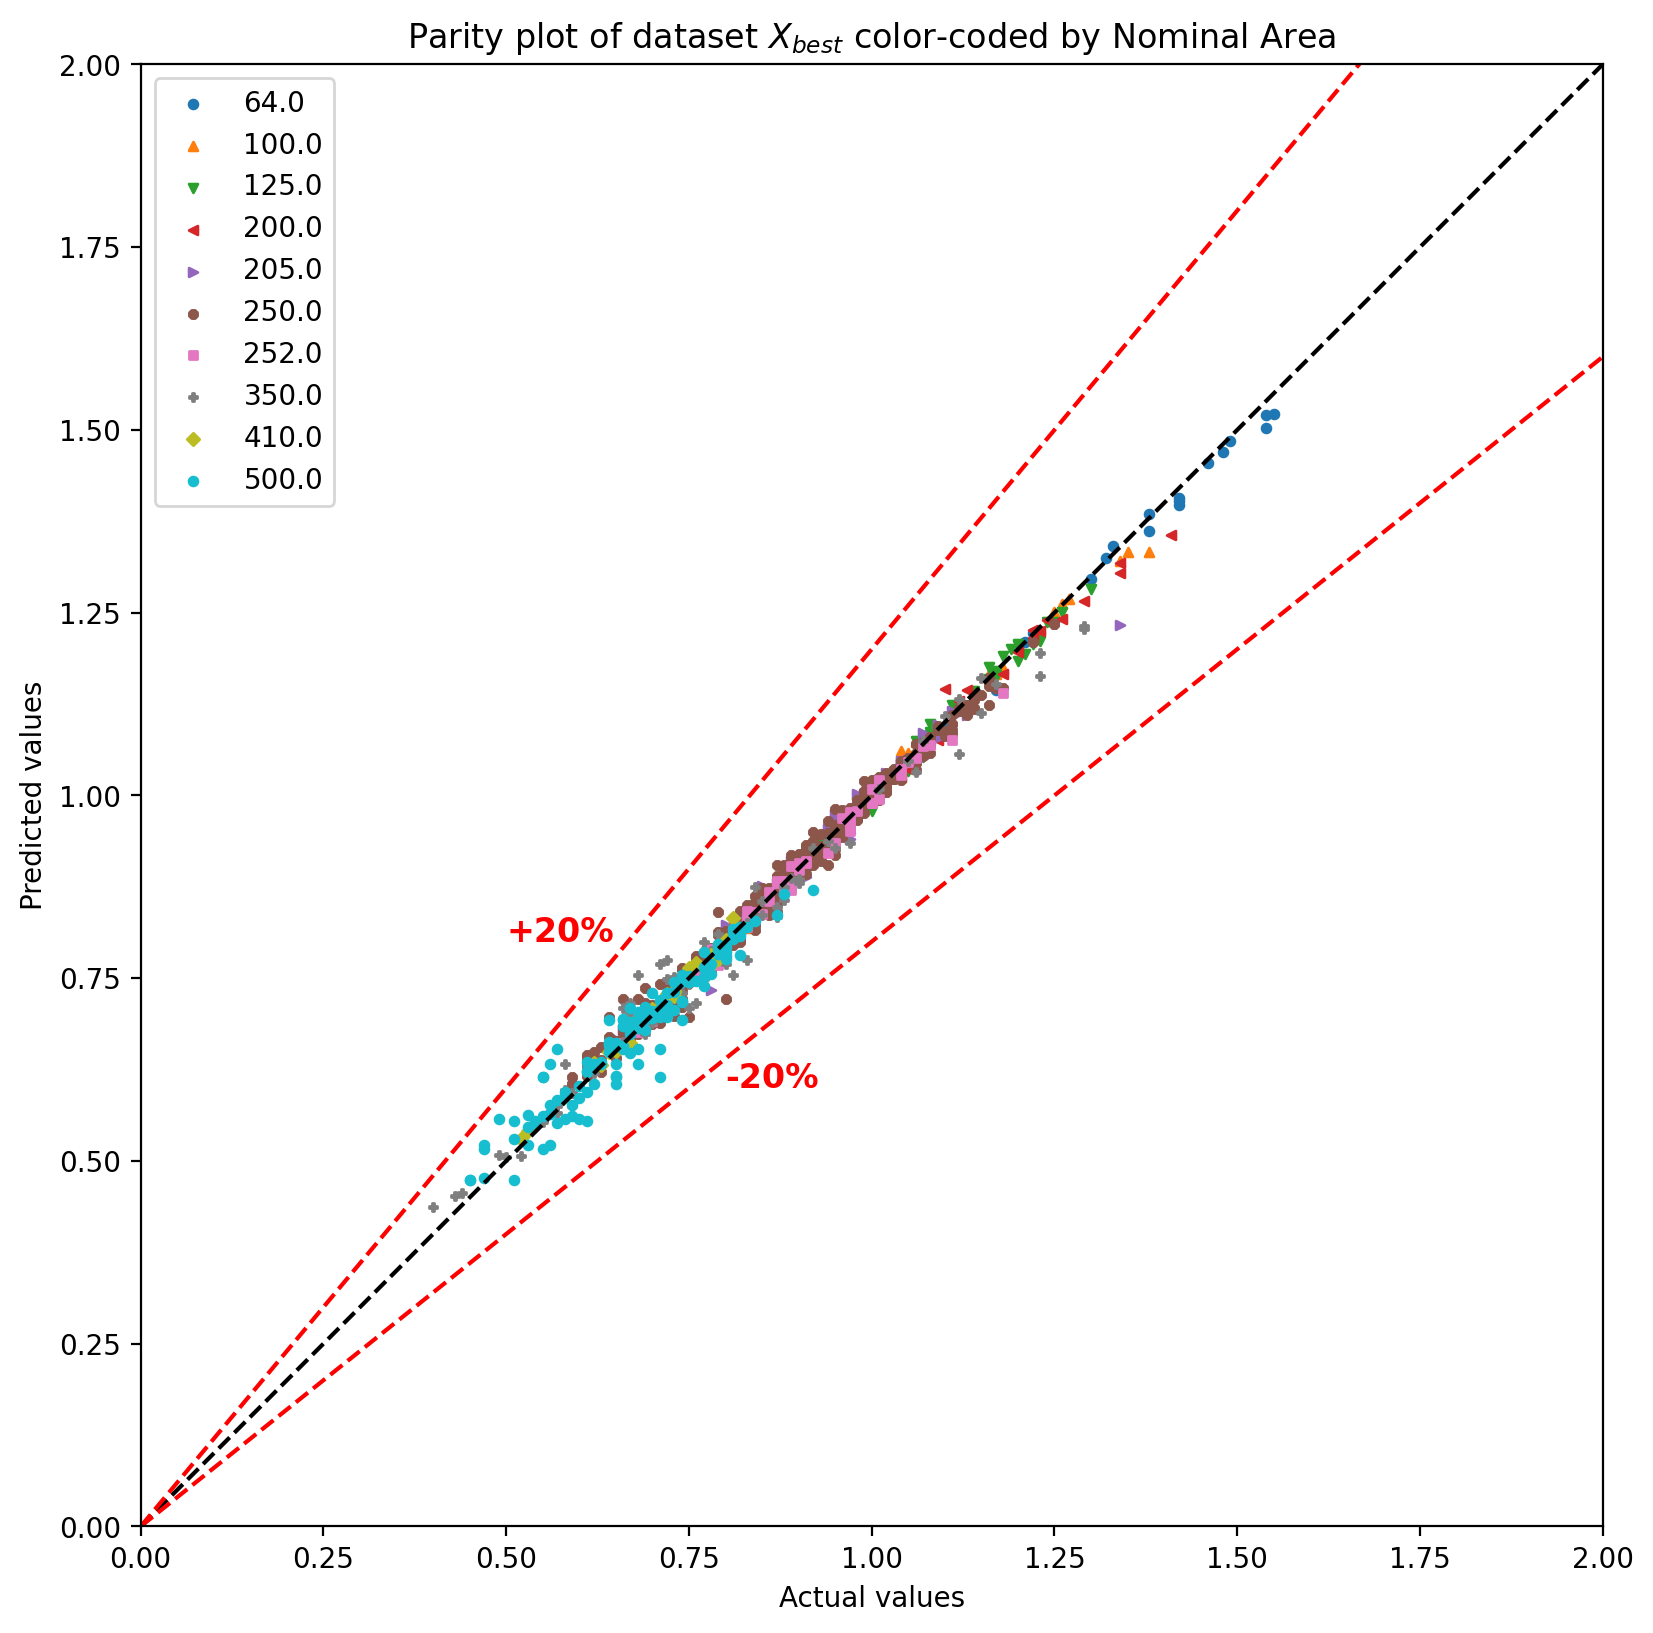

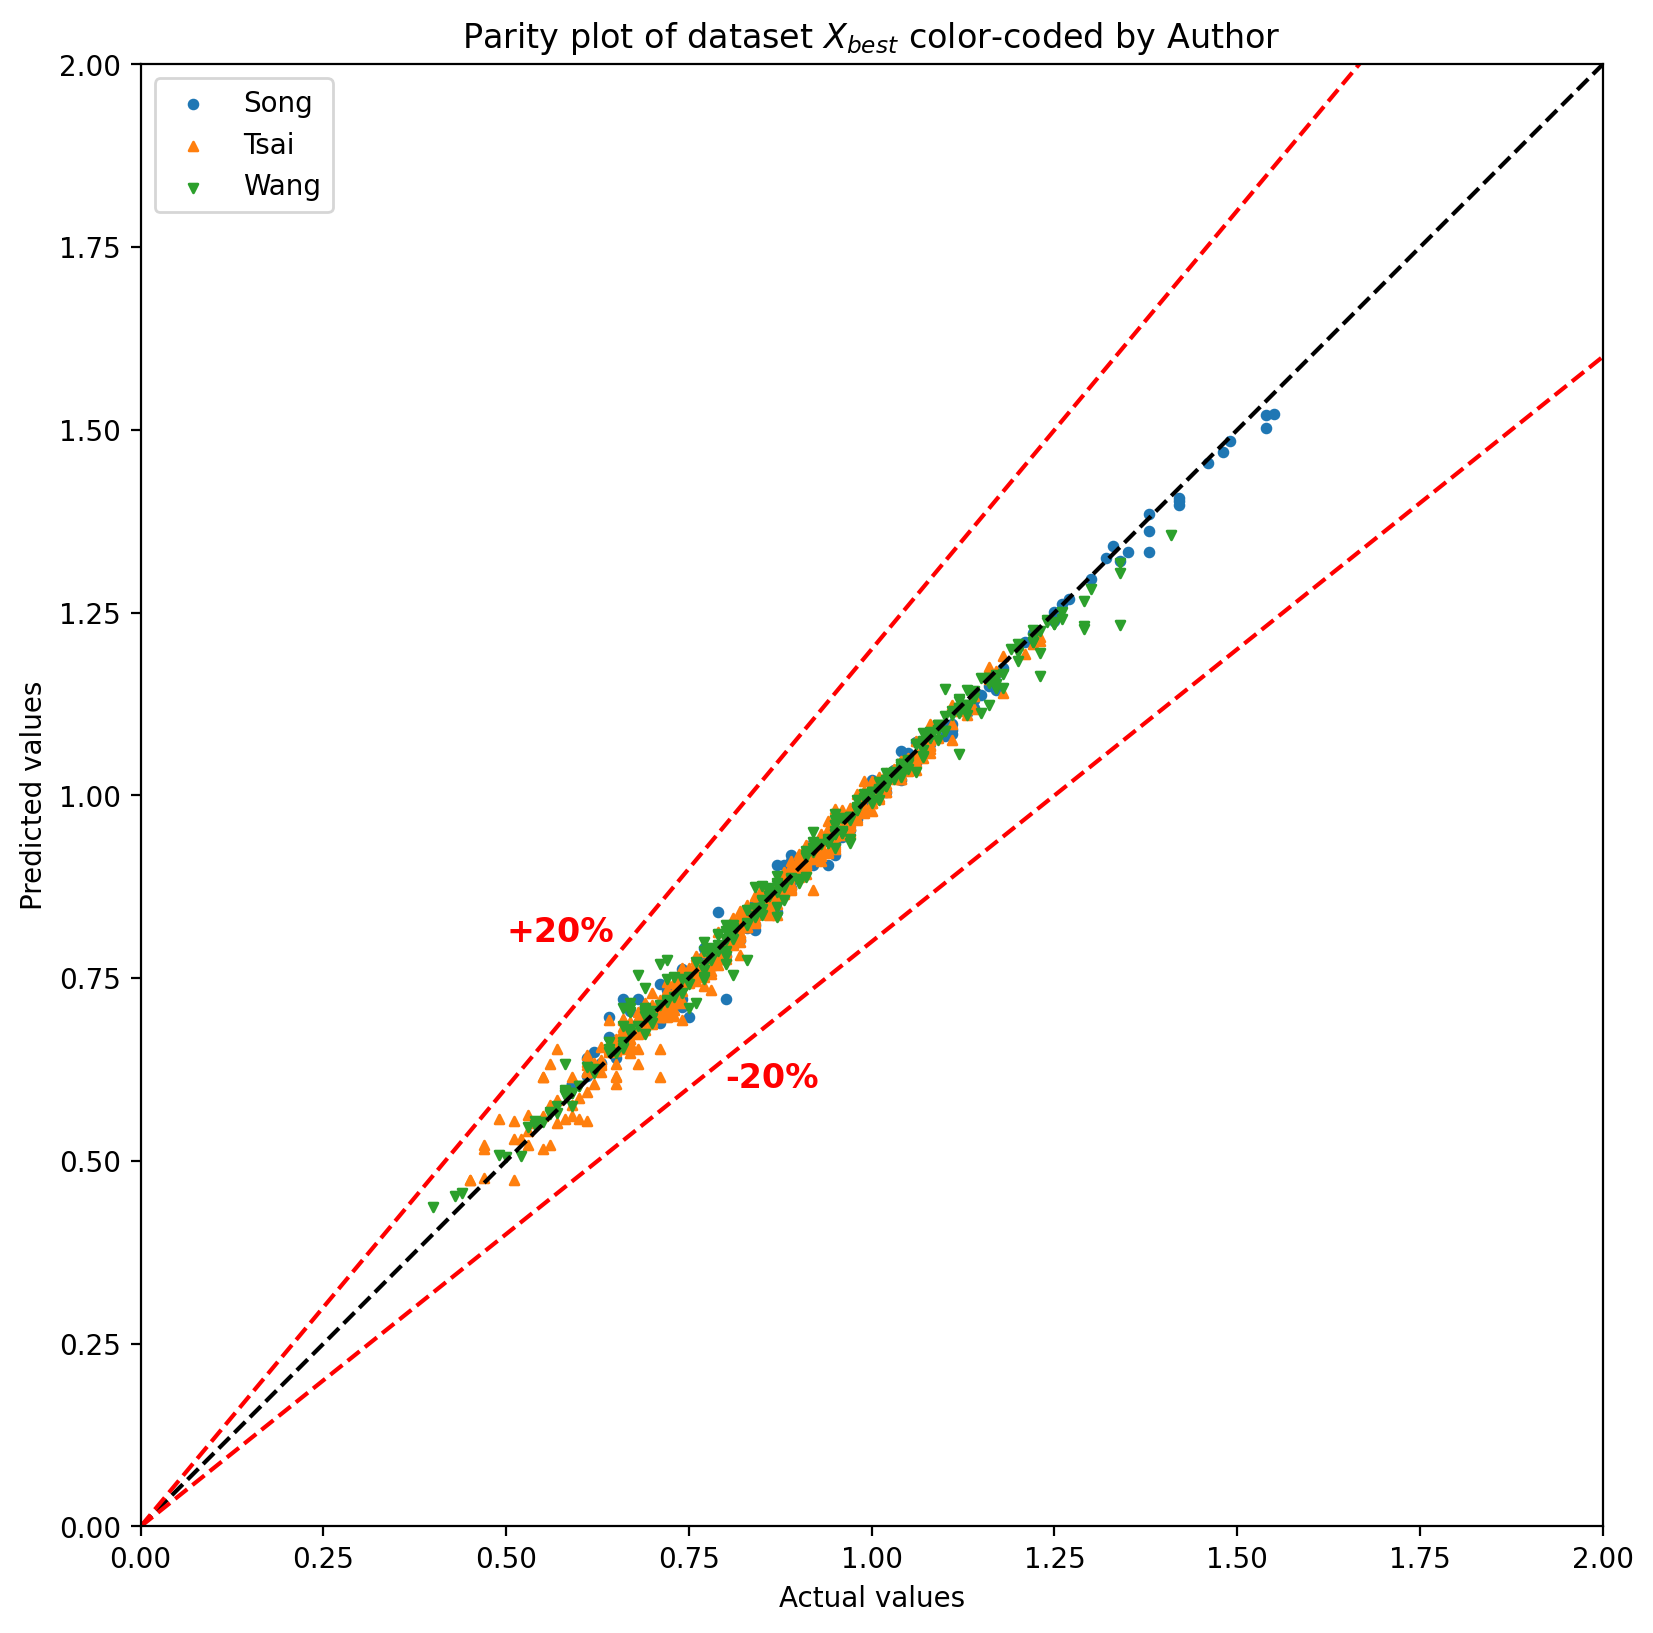

In [41]:
#Color-coded parity plots for Xbest
X_best_labeled = X_best.copy()
X_best_labeled['Packing Type'] = data_struct['Packing Type'].values
#nominal areas are minmaxed scaled from 64 to 500, this line undoes the scaling
X_best_labeled['Nominal Area'] = (data_struct['specific area'].values*(500-64)+64).round()
X_best_labeled['Author'] = data_struct['Who?'].values
rf_best.fit(X_best, Y)
Y_pred = rf_best.predict(X_best)

#Y_train, Y_test, Y_pred_train, Y_pred_test = predict_RF(svm_best, X_best, Y)

parity_plot_color(Y, Y_pred, colors=X_best_labeled, grouping='Packing Type', name=r'$X_{best}$', error=20, dpi=dpi, size=10)
parity_plot_color(Y, Y_pred, colors=X_best_labeled, grouping='Nominal Area', name=r'$X_{best}$', error=20, dpi=dpi, size=10)
parity_plot_color(Y, Y_pred, colors=X_best_labeled, grouping='Author', name=r'$X_{best}$', error=20, dpi=dpi, size=10)

# Permutation Importance

In [42]:
#Feature importance using sklearn permutation importance
def importance_plot(rf, X, Y, name='X', dpi=200):
  importance = permutation_importance(rf, X, Y, n_repeats=50, random_state=17, n_jobs=-1)

  fig, ax = plt.subplots(dpi=dpi)
  ax.bar(range(X.shape[1]), importance.importances_mean)
  ax.set_xticks(range(X.shape[1]))
  ax.set_xticklabels([X.columns[i] for i in range(X.shape[1])], rotation=45, ha='right')
  ax.set_ylabel('Importance score')
  ax.set_title(r'Permutation importance of '+name)
  plt.show()
  return

Base stats:
Training MSE: 0.0% ± 0.0%
Training R^2: 99.3% ± 0.0%
Training MAE: 1.2% ± 0.0%
Testing MSE: 0.2% ± 0.0%
Testing R^2: 95.1% ± 0.2%
Testing MAE: 3.2% ± 0.0%


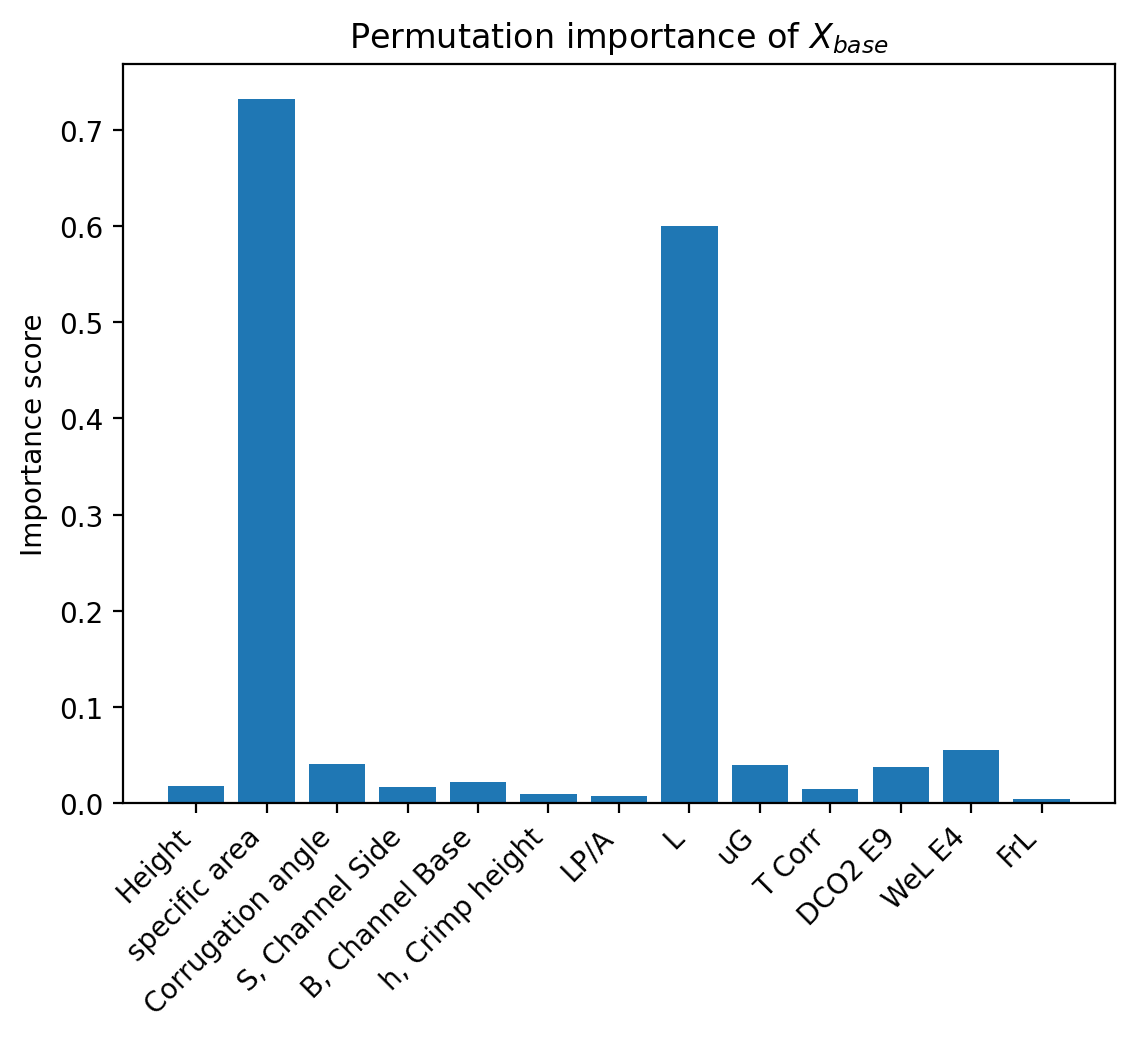

Reduced stats:
Training MSE: 0.1% ± 0.0%
Training R^2: 96.9% ± 0.0%
Training MAE: 2.7% ± 0.0%
Testing MSE: 0.5% ± 0.0%
Testing R^2: 87.6% ± 0.4%
Testing MAE: 5.2% ± 0.1%


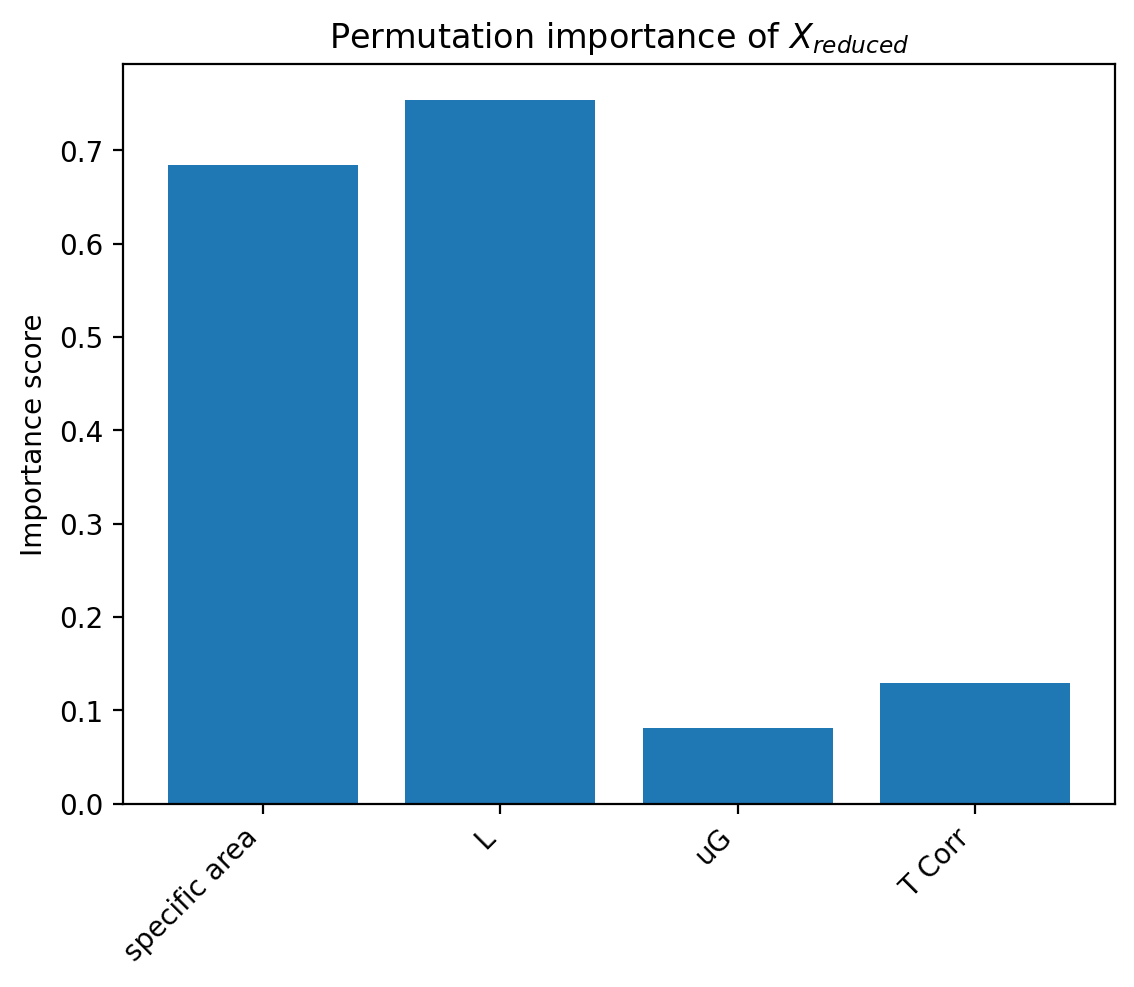

Best stats:
Training MSE: 0.0% ± 0.0%
Training R^2: 99.0% ± 0.0%
Training MAE: 1.4% ± 0.0%
Testing MSE: 0.2% ± 0.0%
Testing R^2: 94.5% ± 0.2%
Testing MAE: 3.4% ± 0.0%


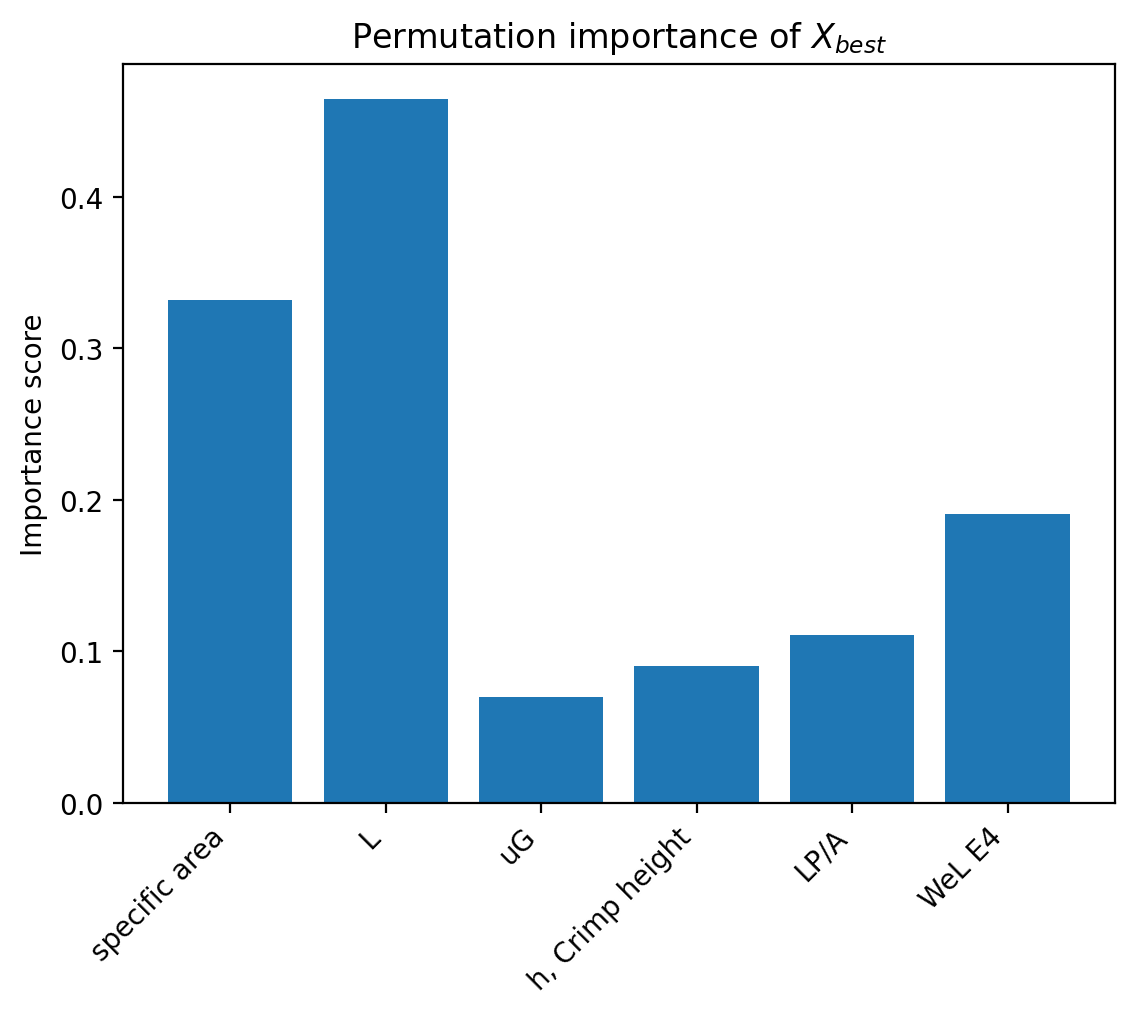

In [44]:
print('Base stats:')
train_stats_base, test_stats_base = fit_RF(rf, X_base, Y, iterations=100, test_size=0.2, print_stats=True)
importance_plot(rf, X_base, Y, name=r'$X_{base}$', dpi=dpi)
print('Reduced stats:')
train_stats_reduced, test_stats_reduced = fit_RF(rf_reduced, X_reduced, Y, iterations=100, test_size=0.2, print_stats=True)
importance_plot(rf_reduced, X_reduced, Y, name=r'$X_{reduced}$', dpi=dpi)
print('Best stats:')
train_stats_best, test_stats_best = fit_RF(rf_best, X_best, Y, iterations=100, test_size=0.2, print_stats=True)
importance_plot(rf_best, X_best, Y, name=r'$X_{best}$', dpi=dpi)

# Random Forest Visualization

In [45]:
g = 9.8 #m/s^2
rho_L = 1000 #kg/m^3 (water)
sigma = 72 #mN/m (water)
eta = 1 #value for structured packing, stainless steel, pre-loading zone
specific_area = 250 #m^2/m^3
T = 25 #degC
corrugation_angle = 45 #degrees
uG = 1.5 #m/s
DCO2 = 2.07 #m^2/s (typical value for 25 degC)
params = f'Fixed parameters:\ng={g}\nrho={rho_L}\nsigma={sigma}\neta={eta}\nT={T}\ncorrugation angle={corrugation_angle}\nuG={uG}\nDCO2={DCO2}'

def Wang(a_p, rho_L, sigma, g, u_L):
  a_e = a_p * 1.34 * (rho_L/sigma*g**(1/3)*(u_L/a_p)**(4/3))**0.116
  fractional_area = a_e/a_p
  return fractional_area

def Song(a_p, rho_L, sigma, g, u_L, eta):
  a_e = a_p * 1.16 * (rho_L/sigma*g**(1/2)*u_L*a_p**(-3/2))**0.138
  fractional_area = a_e/a_p
  return fractional_area

In [46]:
url_nonSRP = 'https://github.com/bdrewr/FinalProjectSDS384/raw/main/UTSRP_SelectedTomography_Svensen.csv' #Unscaled data from non-UT SRP sources
data_nonSRP = pd.read_csv(url_nonSRP)
#drop data by Song, Wang, Tsai
SWT = data_nonSRP["Who?"].str.startswith(('Song','Wang','Tsai'))
data_nonSRP = data_nonSRP.loc[~SWT]
#drop features except for minimum list
#data_nonSRP = data_nonSRP[(reduced_list+['Fractional Area'])]
#Sources did not list T? All appear to be at room temp
data_nonSRP['T Corr'] = 25
data_nonSRP.info()
data_nonSRP.head(5)

def filter_data(df, specific_area, uG=1.0, corrugation_angle=45.0):
  df = df[df['specific area']>specific_area-10]
  df = df[df['specific area']<specific_area+10]
  df = df[df['uG']>uG-0.1]
  df = df[df['uG']<uG+0.1]
  df = df[df['Corrugation angle']>corrugation_angle-1.0]
  df = df[df['Corrugation angle']<corrugation_angle+1.0]
  df = df[df['T Corr']>25-3]
  df = df[df['T Corr']<25+3]
  #df = df[df['DCO2 E9']>2]
  #df = df[df['DCO2 E9']<2.2]
  L = df['L']
  fractional_area = df['Fractional Area']
  print(f'DF has {df.shape[0]} rows matching specific area = {specific_area}, uG = {uG}, and corrugation angle={corrugation_angle}')
  return [L, fractional_area]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 983 to 1258
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              276 non-null    int64  
 1   Packing Type            276 non-null    object 
 2   Height                  276 non-null    float64
 3   specific area           276 non-null    int64  
 4   Corrugation angle       259 non-null    float64
 5   S, Channel Side         67 non-null     float64
 6   B, Channel Base         82 non-null     float64
 7   h, Crimp height         82 non-null     float64
 8   packing element height  276 non-null    float64
 9   void fraction           243 non-null    float64
 10  LP/A                    0 non-null      float64
 11  L                       276 non-null    float64
 12  uG                      276 non-null    float64
 13  T Corr                  276 non-null    int64  
 14  DelP                    0 non-null     

#SHAP and PDP

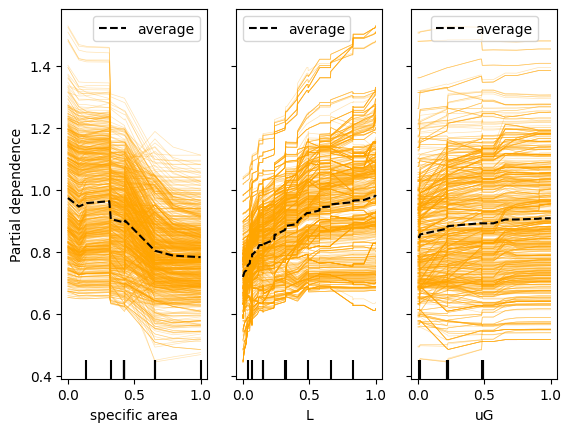

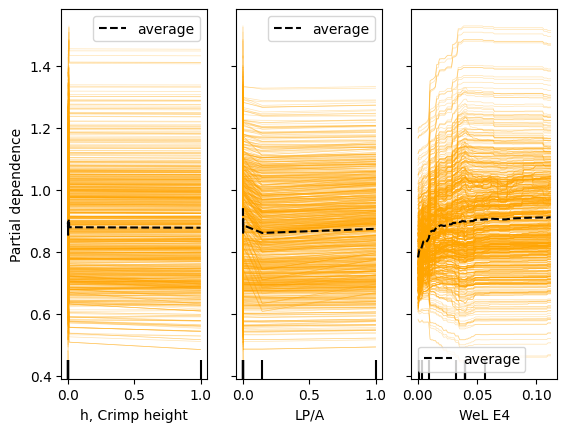

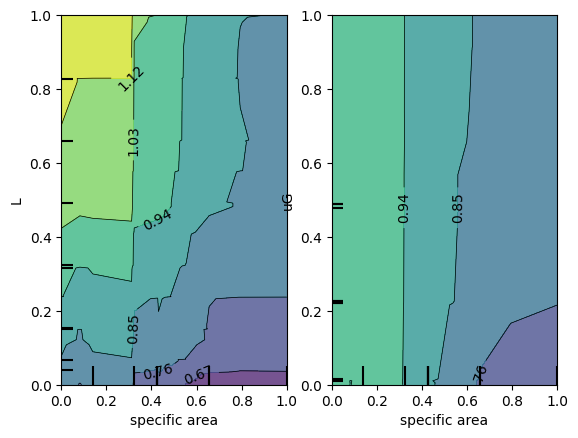

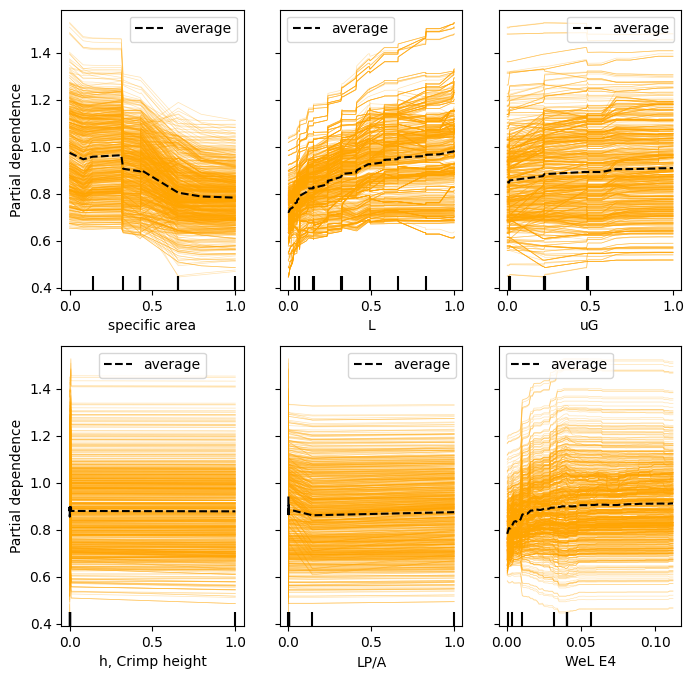

In [75]:
#For the Structured Packing
features_1 = [0,1,2]
features_1_2 = [3,4,5]
features_2way_1 = [(0,1),(0,2)]
features_2way_2 = [(0,3),(2,3)]

features_1way = [0,1,2,3,4,5]
features_2way = [(0,1),(0,2),(0,3),(2,3)]

PDP_Single_1 = PartialDependenceDisplay.from_estimator(rf_best,X_best,features_1,kind = 'both',ice_lines_kw = {"color": "orange"},line_kw = {"color" : "black"})
PDP_Single_2 = PartialDependenceDisplay.from_estimator(rf_best,X_best,features_1_2, kind = 'both',ice_lines_kw = {"color": "orange"},line_kw = {"color" : "black"})
PDP_Double = PartialDependenceDisplay.from_estimator(rf_best,X_best,features_2way_1)

fig1, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
PDP_Single_1.plot(ax=ax1,ice_lines_kw = {"color": "orange"},line_kw = {"color" : "black"})
PDP_Single_2.plot(ax=ax2,ice_lines_kw = {"color": "orange"},line_kw = {"color" : "black"})

plt.show()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


  0%|          | 0/200 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

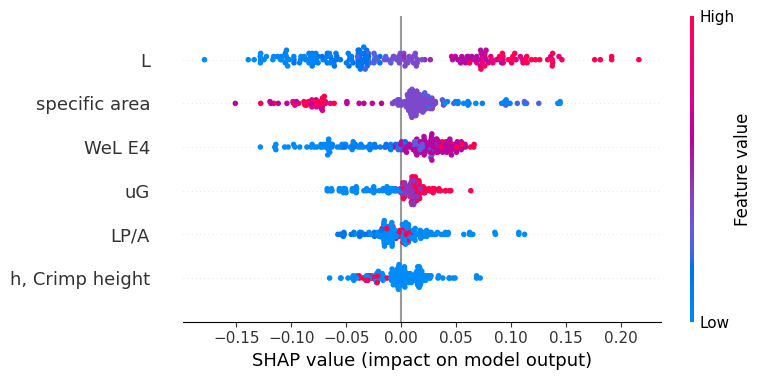

In [68]:
#SHAP
#features =  ['specific area', 'Corrugation angle','L', 'uG', 'T Corr', 'DCO2 E9']
#X_train, X_test, Y_train, Y_test = train_test_split(X_best, Y, test_size=0.2, random_state=17)
shap_sample = shap.utils.sample(X_best, nsamples=200, random_state=17)
explainer = shap.KernelExplainer(rf_best.predict,shap_sample)
shap_values = explainer.shap_values(shap_sample)
# summarize the effects of all the features
shap.summary_plot(shap_values,shap_sample,feature_names=best_combo)